# GIF MAKER USING GANS

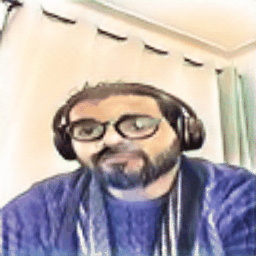

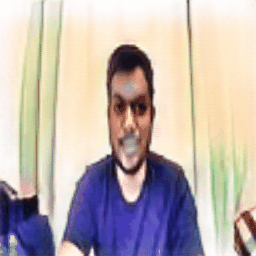

In [128]:
## Scroll at the end to view more results

In [ ]:
import os
import pickle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install scipy==1.1.0

In [ ]:
import itertools, imageio, torch, random
import time
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
from torchvision import datasets
from scipy.misc import imresize
from torch.autograd import Variable
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import transforms
  
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
args = {'name': 'sample_data', 
        'src_data': 'src_data_path', 
        'tgt_data': 'tgt_data_path', 
        'vgg_model': 'pre_trained_VGG19_model_path/vgg19.pth', 
        'in_ngc': 3, 
        'out_ngc': 3, 
        'in_ndc': 3, 
        'out_ndc': 1, 
        'batch_size': 8, 
        'ngf': 64, 
        'ndf': 32, 
        'nb': 8, 
        'input_size': 256, 
        'train_epoch': 40, 
        'pre_train_epoch': 10, 
        'lrD': 0.0002, 
        'lrG': 0.0002, 
        'con_lambda': 10, 
        'beta1': 0.5, 
        'beta2': 0.999, 
        'latest_generator_model': '', 
        'latest_discriminator_model': ''}

In [ ]:
def data_load(path, subfolder, transform, batch_size, shuffle=False, drop_last=True):
    dset = datasets.ImageFolder(path, transform)
    ind = dset.class_to_idx[subfolder]

    n = 0
    for i in range(dset.__len__()):
        if ind != dset.imgs[n][1]:
            del dset.imgs[n]
            n -= 1

        n += 1

    return torch.utils.data.DataLoader(dset, batch_size=batch_size, shuffle=shuffle, drop_last=drop_last)

def print_network(net):
    num_params = 0
    for param in net.parameters():
        num_params += param.numel()
    print(net)
    print('Total number of parameters: %d' % num_params)

In [ ]:
# data_loader
# input_size is 256x256
src_transform = transforms.Compose([
        transforms.Resize((args['input_size'], args['input_size'])),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])
tgt_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

In [ ]:
data_path = '/content/drive/MyDrive/archive/ds_data'

In [ ]:
train_loader_src = data_load(os.path.join(data_path, 'src_data'), 'train', src_transform, args['batch_size'], shuffle=True, drop_last=True)
train_loader_tgt = data_load(os.path.join(data_path, 'tgt_data'), 'pair', tgt_transform, args['batch_size'], shuffle=True, drop_last=True)
test_loader_src = data_load(os.path.join(data_path, 'src_data'), 'test', src_transform, 1, shuffle=True, drop_last=True)

In [ ]:
def initialize_weights(net):
    for m in net.modules():
        if isinstance(m, nn.Conv2d):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()
        elif isinstance(m, nn.ConvTranspose2d):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()
        elif isinstance(m, nn.Linear):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()
        elif isinstance(m, nn.BatchNorm2d):
            m.weight.data.fill_(1)
            m.bias.data.zero_()
            
class resnet_block(nn.Module):
    def __init__(self, channel, kernel, stride, padding):
        super(resnet_block, self).__init__()
        self.channel = channel
        self.kernel = kernel
        self.strdie = stride
        self.padding = padding
        self.conv1 = nn.Conv2d(channel, channel, kernel, stride, padding)
        self.conv1_norm = nn.InstanceNorm2d(channel)
        self.conv2 = nn.Conv2d(channel, channel, kernel, stride, padding)
        self.conv2_norm = nn.InstanceNorm2d(channel)

        initialize_weights(self)

    def forward(self, input):
        x = F.relu(self.conv1_norm(self.conv1(input)), True)
        x = self.conv2_norm(self.conv2(x))

        return input + x #Elementwise Sum
 

class generator(nn.Module):
    # initializers
    def __init__(self, in_nc, out_nc, nf=32, nb=6):
        super(generator, self).__init__()
        self.input_nc = in_nc
        self.output_nc = out_nc
        self.nf = nf
        self.nb = nb
        self.down_convs = nn.Sequential(
            nn.Conv2d(in_nc, nf, 7, 1, 3), #k7n64s1
            nn.InstanceNorm2d(nf),
            nn.ReLU(True),
            nn.Conv2d(nf, nf * 2, 3, 2, 1), #k3n128s2
            nn.Conv2d(nf * 2, nf * 2, 3, 1, 1), #k3n128s1
            nn.InstanceNorm2d(nf * 2),
            nn.ReLU(True),
            nn.Conv2d(nf * 2, nf * 4, 3, 2, 1), #k3n256s1
            nn.Conv2d(nf * 4, nf * 4, 3, 1, 1), #k3n256s1
            nn.InstanceNorm2d(nf * 4),
            nn.ReLU(True),
        )

        self.resnet_blocks = []
        for i in range(nb):
            self.resnet_blocks.append(resnet_block(nf * 4, 3, 1, 1))

        self.resnet_blocks = nn.Sequential(*self.resnet_blocks)

        self.up_convs = nn.Sequential(
            nn.ConvTranspose2d(nf * 4, nf * 2, 3, 2, 1, 1), #k3n128s1/2
            nn.Conv2d(nf * 2, nf * 2, 3, 1, 1), #k3n128s1
            nn.InstanceNorm2d(nf * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(nf * 2, nf, 3, 2, 1, 1), #k3n64s1/2
            nn.Conv2d(nf, nf, 3, 1, 1), #k3n64s1
            nn.InstanceNorm2d(nf),
            nn.ReLU(True),
            nn.Conv2d(nf, out_nc, 7, 1, 3), #k7n3s1
            nn.Tanh(),
        )

        initialize_weights(self)

    # forward method
    def forward(self, input):
        x = self.down_convs(input)
        x = self.resnet_blocks(x)
        output = self.up_convs(x)

        return output


class discriminator(nn.Module):
    # initializers
    def __init__(self, in_nc, out_nc, nf=32):
        super(discriminator, self).__init__()
        self.input_nc = in_nc
        self.output_nc = out_nc
        self.nf = nf
        self.convs = nn.Sequential(
            nn.Conv2d(in_nc, nf, 3, 1, 1),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(nf, nf * 2, 3, 2, 1),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(nf * 2, nf * 4, 3, 1, 1),
            nn.InstanceNorm2d(nf * 4),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(nf * 4, nf * 4, 3, 2, 1),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(nf * 4, nf * 8, 3, 1, 1),
            nn.InstanceNorm2d(nf * 8),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(nf * 8, nf * 8, 3, 1, 1),
            nn.InstanceNorm2d(nf * 8),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(nf * 8, out_nc, 3, 1, 1),
            nn.Sigmoid(),
        )

        initialize_weights(self)

    # forward method
    def forward(self, input):
        # input = torch.cat((input1, input2), 1)
        output = self.convs(input)

        return output


class VGG19(nn.Module):
    def __init__(self, init_weights=None, feature_mode=False, batch_norm=False, num_classes=1000):
        super(VGG19, self).__init__()
        self.cfg = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M']
        self.init_weights = init_weights
        self.feature_mode = feature_mode
        self.batch_norm = batch_norm
        self.num_clases = num_classes
        self.features = self.make_layers(self.cfg, batch_norm)
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )
        if not init_weights == None:
            self.load_state_dict(torch.load(init_weights))

    def make_layers(self, cfg, batch_norm=False):
        layers = []
        in_channels = 3
        for v in cfg:
            if v == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
                if batch_norm:
                    layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
                else:
                    layers += [conv2d, nn.ReLU(inplace=True)]
                in_channels = v
        return nn.Sequential(*layers)

    def forward(self, x):
        if self.feature_mode:
            module_list = list(self.features.modules())
            for l in module_list[1:27]:                 # conv4_4
                x = l(x)
        if not self.feature_mode:
            x = x.view(x.size(0), -1)
            x = self.classifier(x)

        return x

## Inference and GIF Maker


In [ ]:
gen_model_path = '/content/drive/MyDrive/archive/ds_data/epochs50/generator_79.pkl'

In [ ]:
def get_generator_model(model_path):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    if torch.backends.cudnn.enabled:
        torch.backends.cudnn.benchmark = True

    Gen = generator(args['in_ngc'], args['out_ngc'], args['ngf'], args['nb'])
    Gen.load_state_dict(torch.load(model_path))
    Gen.to(device)
    return Gen

In [ ]:
def image_loader(image_name,loader):
    """load image, returns cuda tensor"""
    image = Image.open(image_name)
    image = loader(image).float()
    # image = Variable(image, requires_grad=True)
    image = image.unsqueeze(0)  #this is for VGG, may not be needed for ResNet
    return image.cuda()  #assumes that you're using GPU


In [ ]:
def generate_image_gans(model,image_path):
    src_transform = transforms.Compose([
        transforms.Resize((256,256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])
    image_tensor = image_loader(image_path,src_transform)
    G_recon = model(image_tensor)
    reshaped = (G_recon.squeeze().detach().cpu().numpy().transpose(1, 2, 0) + 1) / 2
    return reshaped

## GIF Maker

In [ ]:
import cv2, imageio

In [ ]:
gen_model_path = '/content/drive/MyDrive/archive/ds_data/epochs50/generator_79.pkl'

In [ ]:
def create_gif(input_path,output_path,giflen=5): 
    # load generator
    gen = get_generator_model(gen_model_path)
    # Path to video file 
    vidObj = cv2.VideoCapture(input_path) 
    length = int(vidObj.get(cv2.CAP_PROP_FRAME_COUNT))-1
    print( length )
    offset=length//giflen
  
    # Used as counter variable 
    count = 0
  
    # checks whether frames were extracted 
    success = 1
    img_lst=[]
    reconds = []
    while success: 
  
        # vidObj object calls read 
        # function extract frames 
        success, image = vidObj.read() 

        # Saves the frames with frame-count 
        if success==1:
          if count%offset == 0:
            H,W,C = image.shape
            cv2.imwrite("frame%d.jpg" % count, image) 
            img_name = "frame%d.jpg"%count
            # apply transformation here and save again with same name
            recond = generate_image_gans(gen,img_name)
            reconds.append(recond)
            cv2.imwrite("cartoon%d.jpg" % count, recond) 

            # 
            img_name = "cartoon%d.jpg"%count
            img_lst.append(img_name)
  
        count += 1
    
    # for img in img_lst:
    #   #cartoonize function

    images = []
    for img in img_lst:
      images.append(imageio.imread(img))
    imageio.mimsave(output_path, images)
    return reconds

In [ ]:
for which in range(70,75,1):
    gen_model_path = '/content/drive/MyDrive/archive/ds_data/epochs50/generator_{}.pkl'.format(which)
    imgs = create_gif(input_path="/content/nitesh.mp4",output_path='/content/original_{}.gif'.format(which),giflen=7)
    imageio.mimsave('/content/nitesh_{}.gif'.format(which),imgs,duration=0.20)

In [ ]:
import matplotlib.image as mpimg

Current GIF: /content/omkar_70.gif


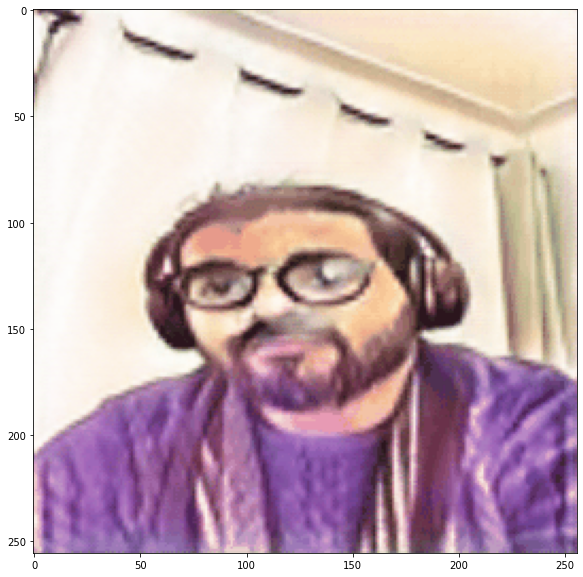

Current GIF: /content/nitesh_70.gif


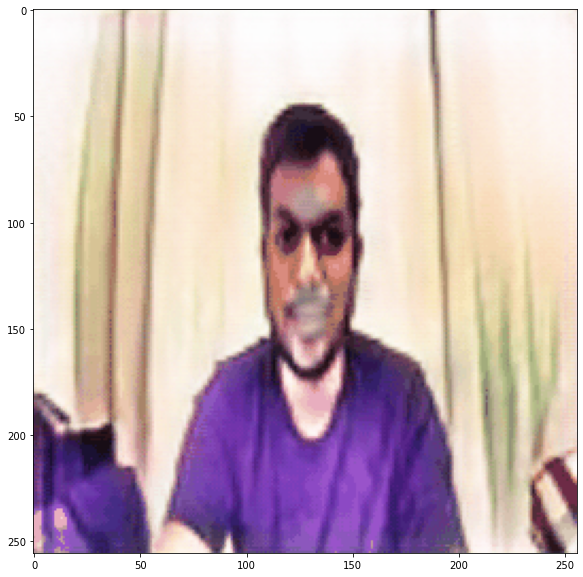

Current GIF: /content/omkar_71.gif


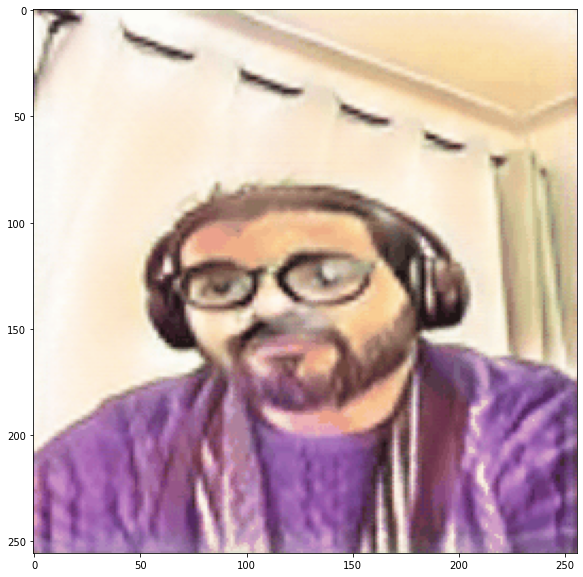

Current GIF: /content/nitesh_71.gif


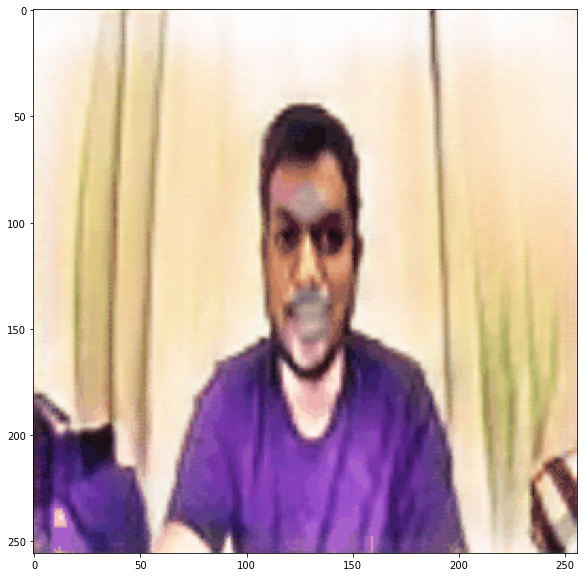

Current GIF: /content/omkar_72.gif


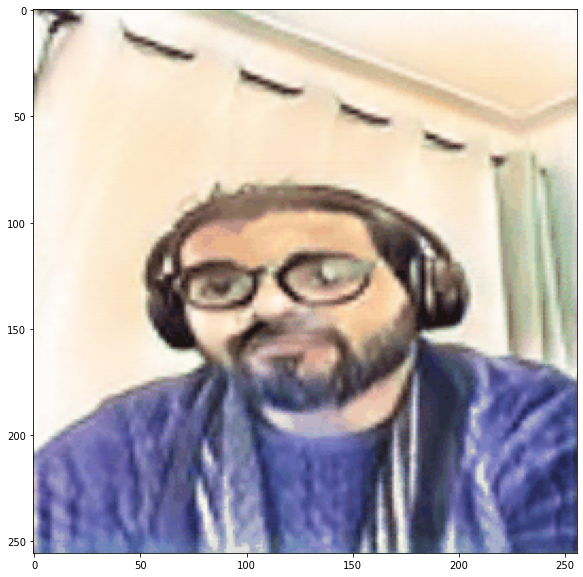

Current GIF: /content/nitesh_72.gif


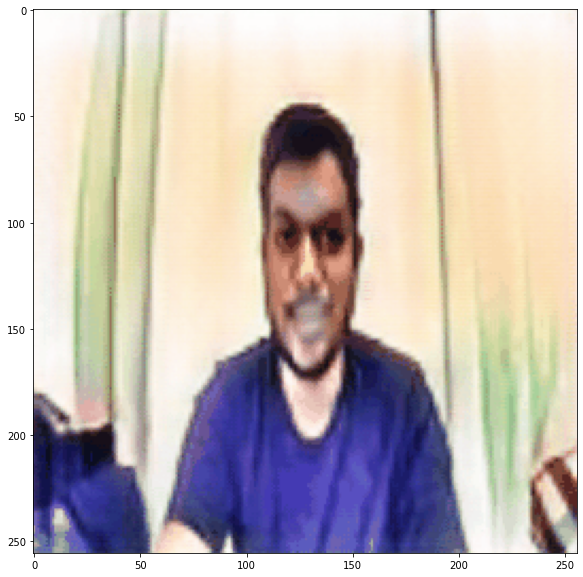

Current GIF: /content/omkar_73.gif


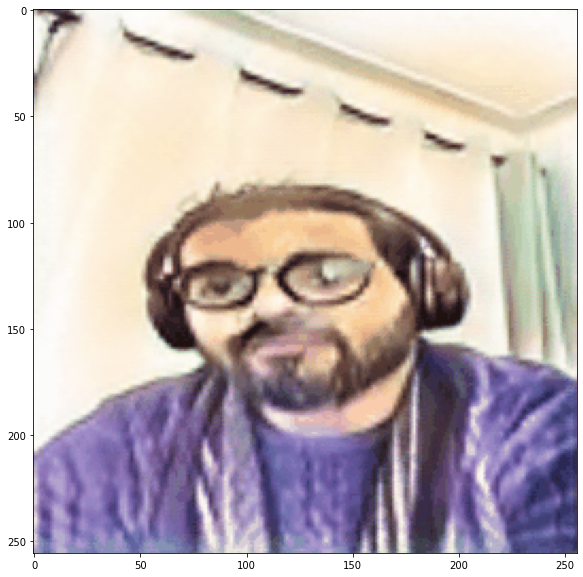

Current GIF: /content/nitesh_73.gif


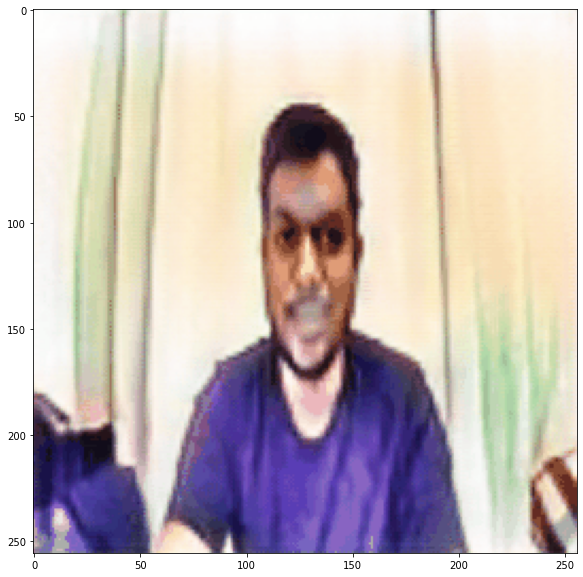

Current GIF: /content/omkar_74.gif


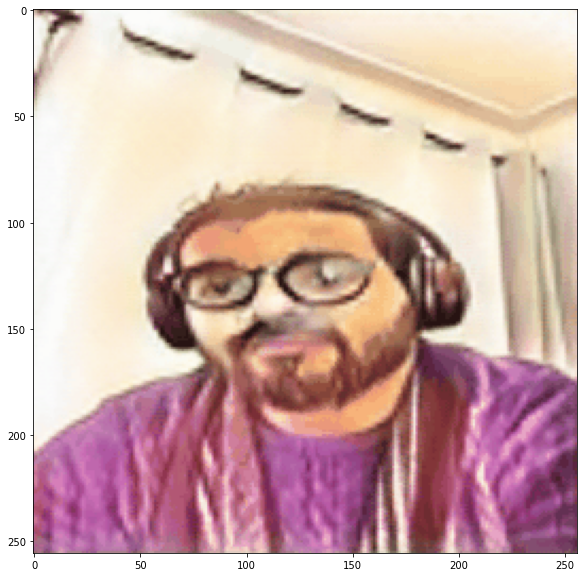

Current GIF: /content/nitesh_74.gif


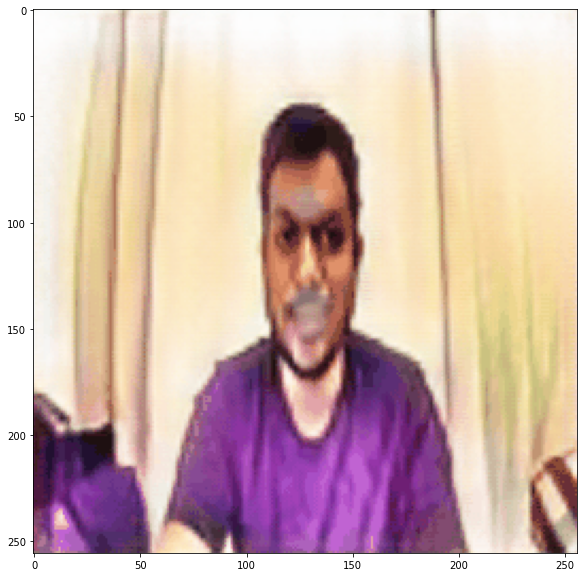

In [127]:
for number in [70,71,72,73,74]:
    for name in ['omkar','nitesh']:
        print('Current GIF: /content/{}_{}.gif'.format(name,number))
        plt.figure(figsize=(10,10))
        img = mpimg.imread('/content/{}_{}.gif'.format(name,number))
        plt.imshow(img)
        plt.show()